In [1]:
import argparse
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.interpolate import interp1d
from scipy.stats import pearsonr, spearmanr
import sys
import time
import torch
import tqdm

In [2]:
sys.path.append(os.path.dirname(os.path.dirname(os.path.realpath("__file__"))))
from examples.mlp import mlp
from dist_ir.ir import Topology
from dist_ir.executor import infer_types, Simulator
from dist_ir.executor.cost_model import CostModel

In [3]:
DEVICE_THROUGHPUT = 6.6e12 # FLOPS
DRAM_BANDWIDTH = 2.7e12 # ???
WORLD_SIZE = 2

In [4]:
class Mlp(torch.nn.Module):
    def __init__(self, num_hidden_layers, hidden_dim):
        super().__init__()
        self.blocks = [
            torch.nn.Linear(hidden_dim, hidden_dim, bias=False)
            for _ in range(num_hidden_layers)
        ]
        for i, block in enumerate(self.blocks):
            for j, param in enumerate(block.parameters()):
                if j > 0:
                    raise ValueError(f"Block {i} has more than 1 parameter!")
                self.register_parameter(f"w{chr(ord('A')+i)}", param)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
            relu = torch.nn.ReLU()
            x = relu(x)
        return x

In [5]:
def run(
    num_hidden_layers,
    batch_size,
    hidden_dim,
    num_warmup_steps=10,
    num_profiling_steps=100,
):
    model = Mlp(num_hidden_layers, hidden_dim).to("cuda:0")
    loss_fn = torch.nn.MSELoss()
    x = torch.randn(size=(batch_size, hidden_dim)).to("cuda:0")
    labels = torch.randn(size=(batch_size, hidden_dim)).to("cuda:0")
    runtimes = []
    for i in tqdm.tqdm(range(num_warmup_steps + num_profiling_steps)):
        start = time.time()
        y = model(x)
        loss_fn(y, labels).backward()
        duration = time.time() - start
        runtimes.append(duration)
    return np.median(runtimes[num_warmup_steps:])

In [6]:
def simulate(num_hidden_layers, batch_size, hidden_dim):
    topology = Topology()
    d0 = topology.add_device(
        "gpu", throughput=DEVICE_THROUGHPUT, dram_bandwidth=DRAM_BANDWIDTH
    )
    function = mlp(
        batch_size, hidden_dim, hidden_dim, hidden_dim, num_hidden_layers, d0
    )
    function = infer_types(function, function.inputs)
    simulator = Simulator(CostModel(topology))
    simulation = simulator.interpret(
        function,
        (v.type for v in function.inputs),
    )
    return simulation.timestamps[d0]

In [7]:
def sweep(all_num_hidden_layers, all_batch_sizes, all_hidden_dims, filename, func):
    fieldnames = ["num_hidden_layers", "batch_size", "hidden_dim", "runtime"]
    with open(filename, "w") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for num_hidden_layers in all_num_hidden_layers:
            for batch_size in all_batch_sizes:
                for hidden_dim in all_hidden_dims:
                    runtime = func(num_hidden_layers, batch_size, hidden_dim)
                    writer.writerow(
                        {
                            "num_hidden_layers": num_hidden_layers,
                            "batch_size": batch_size,
                            "hidden_dim": hidden_dim,
                            "runtime": runtime,
                        }
                    )

In [8]:
def parse_csv(filename):
    results = []
    with open(filename, "r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            results.append(
                (
                    row["num_hidden_layers"],
                    row["batch_size"],
                    row["hidden_dim"],
                    row["runtime"],
                )
            )
    return results

In [9]:
all_num_hidden_layers = [8, 16, 32]
all_batch_sizes = [512, 1024, 2048]
all_hidden_dims = [1024, 2048, 4096]
# sweep(
#     all_num_hidden_layers,
#     all_batch_sizes,
#     all_hidden_dims,
#     "single_device_runtimes.csv",
#     run,
# )
sweep(
    all_num_hidden_layers,
    all_batch_sizes,
    all_hidden_dims,
    "single_device_simulated_runtimes.csv",
    simulate,
)

In [10]:
real_results = parse_csv("single_device_runtimes.csv")
simulated_results = parse_csv("single_device_simulated_runtimes.csv")

In [11]:
real_throughputs = []
simulated_throughputs = []
model_sizes = []
print(f"# layers,batch size,hidden dim,model size (MB),real,simulated,ratio")
for real, simulated in zip(real_results, simulated_results):
    num_hidden_layers = int(real[0])
    batch_size = int(real[1])
    hidden_dim = int(real[2])
    real_runtime = float(real[3])
    simulated_runtime = float(simulated[-1])
    model_size = hidden_dim * hidden_dim * num_hidden_layers * 4 / (1024 * 1024)
    print(
        f"{num_hidden_layers},{batch_size},{hidden_dim},"
        f"{model_size},{real_runtime*1000:.2f},"
        f"{simulated_runtime*1000:.2f},"
        f"{(simulated_runtime/real_runtime):.2f}x"
    )
    real_throughputs.append(batch_size / real_runtime / 1000)
    simulated_throughputs.append(batch_size / simulated_runtime / 1000)
    model_sizes.append(model_size)

# layers,batch size,hidden dim,model size (MB),real,simulated,ratio
8,512,1024,32.0,3.97,3.94,0.99x
8,512,2048,128.0,12.91,15.70,1.22x
8,512,4096,512.0,49.99,62.74,1.26x
8,1024,1024,32.0,6.73,7.86,1.17x
8,1024,2048,128.0,24.28,31.36,1.29x
8,1024,4096,512.0,90.02,125.29,1.39x
8,2048,1024,32.0,12.66,15.70,1.24x
8,2048,2048,128.0,45.76,62.67,1.37x
8,2048,4096,512.0,178.42,250.38,1.40x
16,512,1024,64.0,7.72,7.87,1.02x
16,512,2048,256.0,27.64,31.41,1.14x
16,512,4096,1024.0,115.61,125.48,1.09x
16,1024,1024,64.0,14.69,15.71,1.07x
16,1024,2048,256.0,57.64,62.71,1.09x
16,1024,4096,1024.0,209.08,250.57,1.20x
16,2048,1024,64.0,29.27,31.40,1.07x
16,2048,2048,256.0,105.27,125.33,1.19x
16,2048,4096,1024.0,404.75,500.75,1.24x
32,512,1024,128.0,17.93,15.74,0.88x
32,512,2048,512.0,60.78,62.81,1.03x
32,512,4096,2048.0,243.62,250.97,1.03x
32,1024,1024,128.0,30.13,31.43,1.04x
32,1024,2048,512.0,115.88,125.43,1.08x
32,1024,4096,2048.0,423.42,501.14,1.18x
32,2048,1024,128.0,58.01,62.80,1.08x
32,2048,2048,51

Pearson's correlation: 0.992236389505993 (p=3.7095253771200185e-24)
Spearman's correlation: 0.996947496947497 (p=3.255680677866081e-29)


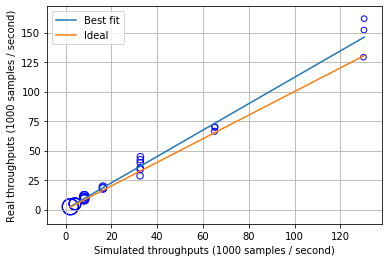

In [12]:
simulated_throughputs = np.array(simulated_throughputs)
real_throughputs = np.array(real_throughputs)
r, p = pearsonr(simulated_throughputs, real_throughputs)
print(f"Pearson's correlation: {r} (p={p})")
r, p = spearmanr(simulated_throughputs, real_throughputs)
print(f"Spearman's correlation: {r} (p={p})")
m, b = np.polyfit(simulated_throughputs, real_throughputs, 1)
x_new = np.linspace(simulated_throughputs.min(), simulated_throughputs.max(), 500)
f = interp1d(simulated_throughputs, m * simulated_throughputs + b, kind="linear")
y_smooth = f(x_new)
plt.plot(x_new, y_smooth, label="Best fit")
plt.plot(x_new, x_new, label="Ideal")
colors=["b", "orange", "g", "purple"]
scaled_model_sizes = np.array(model_sizes, dtype=np.float32)
scaled_model_sizes -= np.min(model_sizes)
scaled_model_sizes *= 1.0 / (np.max(model_sizes) - np.min(model_sizes))
scaled_model_sizes *= 224
scaled_model_sizes += 32
plt.scatter(
    simulated_throughputs,
    real_throughputs,
    s=scaled_model_sizes,
    facecolors="none",
    edgecolors="b",
)
plt.grid()
plt.xlabel("Simulated throughputs (1000 samples / second)")
plt.ylabel("Real throughputs (1000 samples / second)")
plt.legend()
plt.savefig("single_device_simulation_performance.pdf", dpi=600, bbox_inches="tight")